In [1]:
import numpy as np
import pandas as pd
import xarray as xa
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns
from wisdom.statistics import empyrical_mode

In [2]:
sns.set_context("talk")
cmap = sns.color_palette("Spectral_r", as_cmap=True)

In [3]:
inference = xa.open_dataset("../outputs/model_inference_anon.nc")
concerns = inference.samples.mean(dim="draw").to_pandas().T
categories = pd.read_csv("../data/enms_grouping.txt", sep="\t", header=None, names=["nano", "cat"])
concerns_cat = pd.merge(categories, concerns, right_index=True, left_on="nano")

In [13]:
ext = pd.read_excel("../data/external/nn8b07562_si_001.xlsx")
cytotoxicity = (
    ext
    .assign(log_conc=lambda df: np.log10(df["Concentration μM"]))
    .query( "Test == 'MTT'")
    .assign(log_conc_bin=lambda df: pd.cut(df["log_conc"], bins=15))
)
cytotoxicity

,Nanoparticle,Type: Organic (O)/inorganic (I),coat,Diameter (nm),Concentration μM,Zeta potential (mV),Cells,Cell line (L)/primary cells (P),Human(H)/Animal(A) cells,Animal?,...,Biochemical metric,% Cell viability,Interference checked (Y/N),Colloidal stability checked (Y/N),Positive control (Y/N),Publication year,Particle ID,Reference DOI,log_conc,log_conc_bin
0,CeO2,I,NaN,20.3,0.002478,NaN,L929,L,A,Mouse,...,cell metabolic activity,105.58918,N,N,N,2015,1,10.1016/j.ceramint.2014.09.095,-2.605929,"(-2.902, -1.873]"
1,CeO2,I,NaN,20.3,0.004956,NaN,L929,L,A,Mouse,...,cell metabolic activity,103.02621,N,N,N,2015,1,10.1016/j.ceramint.2014.09.095,-2.304899,"(-2.902, -1.873]"
2,CeO2,I,NaN,20.3,0.009911,NaN,L929,L,A,Mouse,...,cell metabolic activity,104.85748,N,N,N,2015,1,10.1016/j.ceramint.2014.09.095,-2.003869,"(-2.902, -1.873]"
3,CeO2,I,NaN,20.3,0.019823,NaN,L929,L,A,Mouse,...,cell metabolic activity,100.09670,N,N,N,2015,1,10.1016/j.ceramint.2014.09.095,-1.702839,"(-1.873, -0.844]"
4,CeO2,I,NaN,20.3,0.039645,NaN,L929,L,A,Mouse,...,cell metabolic activity,97.53237,N,N,N,2015,1,10.1016/j.ceramint.2014.09.095,-1.401809,"(-1.873, -0.844]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,Chitosan,O,Hyaluronic acid,260.0,0.000180,47.0,L929,L,A,Mouse,...,cell metabolic activity,95.50218,N,N,N,2009,118,10.1007/s11095-009-9908-0,-3.743669,"(-3.931, -2.902]"
2892,Chitosan,O,Hyaluronic acid,260.0,0.000180,47.0,L929,L,A,Mouse,...,cell metabolic activity,90.26201,N,N,N,2009,118,10.1007/s11095-009-9908-0,-3.743669,"(-3.931, -2.902]"
2893,Chitosan,O,Hyaluronic acid,260.0,0.000180,47.0,J774,L,A,Mouse,...,cell metabolic activity,89.56332,N,N,N,2009,118,10.1007/s11095-009-9908-0,-3.743669,"(-3.931, -2.902]"
2894,Chitosan,O,Hyaluronic acid,260.0,0.000180,47.0,J774,L,A,Mouse,...,cell metabolic activity,85.37118,N,N,N,2009,118,10.1007/s11095-009-9908-0,-3.743669,"(-3.931, -2.902]"


In [11]:
enm_mapping = pd.DataFrame(
    data=(
        ("Silver", "Ag"),
        ("Silica", "SiO2"),
        ("TiO2_particles", "TiO2"),
        ("Gold", "Au"),
        ("ZnO", "ZnO"),
        ("Other_CNMs", "Carbon NP"),
        ("Copper", "CuO"),
        ("Iron_oxide", "Iron oxide"),
        ("Carbon_nanotubes", "Carbon Nanotubes"),
        ("Cadmium_based_QDs", "QDs"),
        ("Hydroxyapatite", "Hydroxyapatite"),
        ("Polymers", "Eudragit RL"),
        ("Polymers", "PLGA")
    ),
    columns=["WoC", "Ext"],
)

In [16]:
df = (
    pd.merge(
        pd.merge(enm_mapping, categories, left_on="WoC", right_on="cat"),
        concerns["Cytotoxic"],
        left_on="nano",
        right_index=True,
    )
    .groupby("Ext")
    .apply(lambda g: np.mean(g["Cytotoxic"])).reset_index()
    .rename(columns={0: "concern"})
    .sort_values(by="concern", ascending=True)
)

df2 = pd.merge(
    cytotoxicity,
    df,
    left_on="Nanoparticle",
    right_on="Ext"
)
df2

,Nanoparticle,Type: Organic (O)/inorganic (I),coat,Diameter (nm),Concentration μM,Zeta potential (mV),Cells,Cell line (L)/primary cells (P),Human(H)/Animal(A) cells,Animal?,...,Interference checked (Y/N),Colloidal stability checked (Y/N),Positive control (Y/N),Publication year,Particle ID,Reference DOI,log_conc,log_conc_bin,Ext,concern
0,CuO,I,NaN,52.51,3.471326e-05,-39.67,A549,L,H,NaN,...,N,N,N,2010,3,10.1016/j.bbrc.2010.04.156,-4.459505,"(-4.959, -3.931]",CuO,0.990500
1,CuO,I,NaN,52.51,8.678315e-05,-39.67,A549,L,H,NaN,...,N,N,N,2010,3,10.1016/j.bbrc.2010.04.156,-4.061565,"(-4.959, -3.931]",CuO,0.990500
2,CuO,I,NaN,52.51,1.735663e-04,-39.67,A549,L,H,NaN,...,N,N,N,2010,3,10.1016/j.bbrc.2010.04.156,-3.760535,"(-3.931, -2.902]",CuO,0.990500
3,CuO,I,NaN,239.00,3.681525e-11,NaN,HCMEC,P,H,NaN,...,N,Y,N,2011,4,10.1007/s10565-011-9191-9,-10.433972,"(-11.132, -10.103]",CuO,0.990500
4,CuO,I,NaN,239.00,3.681525e-10,NaN,HCMEC,P,H,NaN,...,N,Y,N,2011,4,10.1007/s10565-011-9191-9,-9.433972,"(-10.103, -9.075]",CuO,0.990500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,Carbon NP,O,COONa,5.90,3.431486e-02,NaN,Neuro­2a,L,A,Mouse,...,Y,Y,Y,2007,116,10.1021/jp066387v,-1.464518,"(-1.873, -0.844]",Carbon NP,0.524667
574,Carbon NP,O,SO3Na,5.90,6.862973e-02,NaN,Neuro­2a,L,A,Mouse,...,Y,Y,Y,2007,116,10.1021/jp066387v,-1.163488,"(-1.873, -0.844]",Carbon NP,0.524667
575,Carbon NP,O,SO3Na,5.90,1.715743e-01,NaN,Neuro­2a,L,A,Mouse,...,Y,Y,Y,2007,116,10.1021/jp066387v,-0.765548,"(-0.844, 0.184]",Carbon NP,0.524667
576,Carbon NP,O,SO3Na,5.90,3.431486e-01,NaN,Neuro­2a,L,A,Mouse,...,Y,Y,Y,2007,116,10.1021/jp066387v,-0.464518,"(-0.844, 0.184]",Carbon NP,0.524667


/tmp/ipykernel_16980/405004474.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(nps, rotation=45, ha="right")


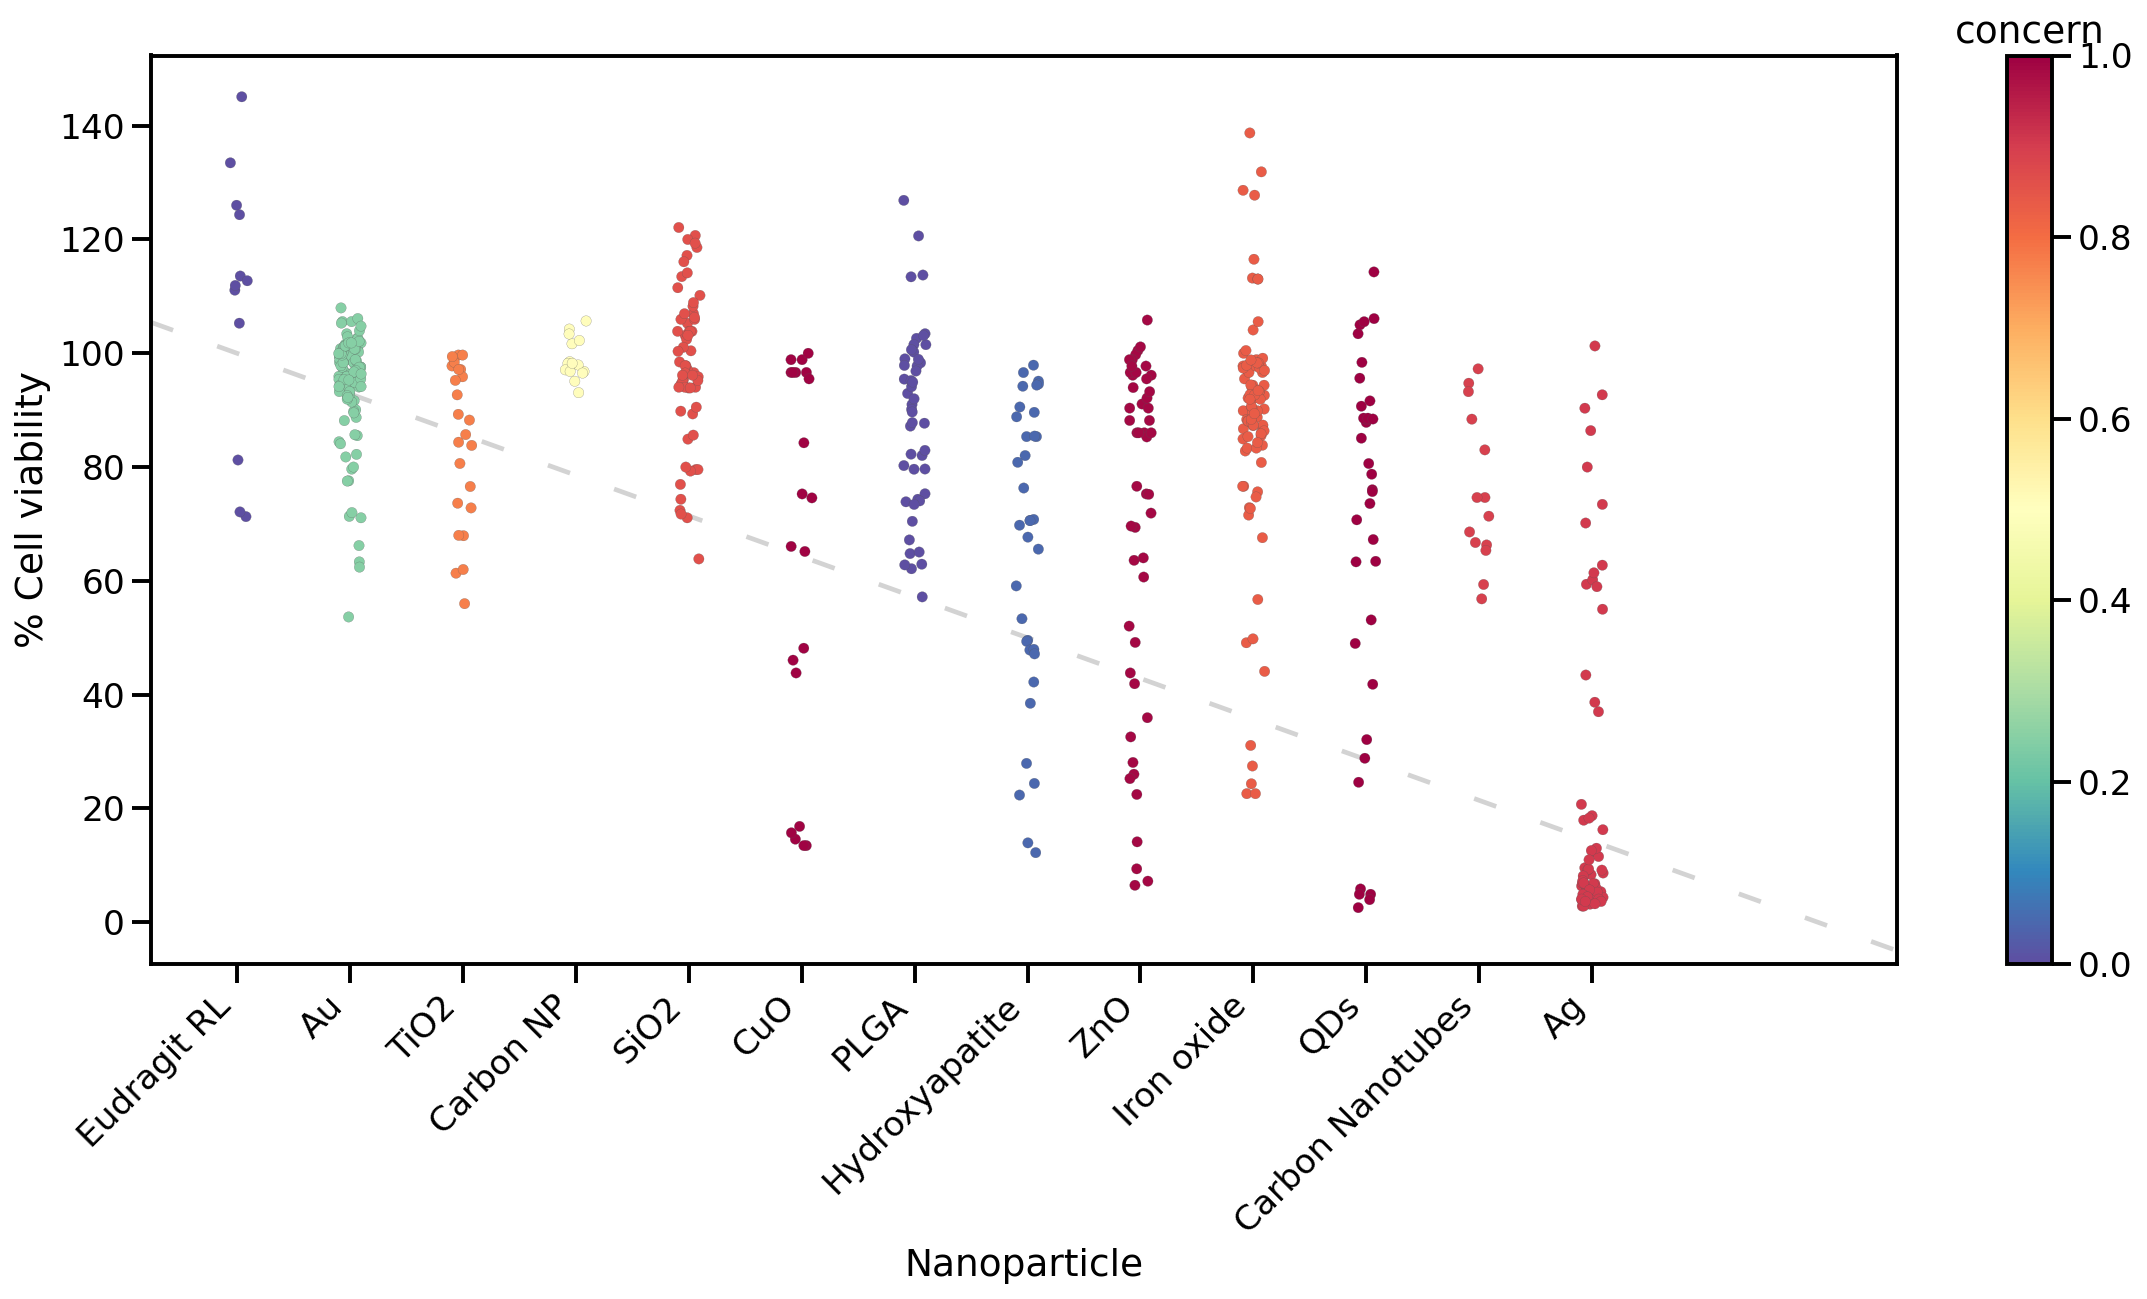

In [17]:
nps = (
    df2
    .groupby("Nanoparticle")["% Cell viability"]
    .apply(empyrical_mode, bins=10)
    .sort_values(ascending=False)
    .index
)
fig, ax = plt.subplots(figsize=(16, 9), dpi=150)
sns.stripplot(
    data=df2,
    x="Nanoparticle",
    y="% Cell viability",
    order=nps,
    hue="concern",
    hue_order=df["concern"].unique(),
    ax=ax,
    palette="Spectral_r",
    edgecolor="#555",
    linewidth=0.1,
    # alpha=0.8,
    vmin=0,
    vmax=1,
)
ax.set_xticklabels(nps, rotation=45, ha="right")
cax = ax.axline([0, 100], [14, 0], linestyle=(0, (5, 10)), c="lightgrey")
ax.legend_.remove()

# This is the part about the colormap
norm = plt.Normalize(0, 1)
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("concern")
plt.tight_layout()